# Artificial Intelligence Nanodegree
## Recurrent Neural Network Projects

Welcome to the Recurrent Neural Network Project in the Artificial Intelligence Nanodegree! In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide.Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

# Problem 1: Perform time series prediction 

In this project you will perform time series prediction using a Recurrent Neural Network regressor.  In particular you will re-create the figure shown in the notes - where the stock price of Apple was forecasted (or predicted) 7 days in advance.  In completing this exercise you will learn how to construct RNNs using Keras, which will also aid in completing the second project in this notebook.

The particular network architecture we will employ for our RNN is known as  [Long Term Short Memory (LSTM)](https://en.wikipedia.org/wiki/Long_short-term_memory), which helps significantly avoid technical problems with optimization of RNNs.  

## 1.1 Getting started

First we must load in our time series - a history of around 140 days of Apple's stock price.  Then we need to perform a number of pre-processing steps to prepare it for use with an RNN model.  First off, it is good practice to normalize time series - by normalizing its range.  This helps us avoid serious numerical issues associated how common activation functions (like tanh) transform very large (positive or negative) numbers, as well as helping us to avoid related issues when computing derivatives.

Here we normalize the series to lie in the range [0,1] [using this scikit function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html), but it is also commonplace to normalize by a series standard deviation.

In [1]:
%pip install -q tensorflow==2.16.2 tf-keras==2.16

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Activation
import keras
import string
import tensorflow as tf

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# Scaling function for the dataset
from sklearn.preprocessing import MinMaxScaler
def scale_data(df, target_column):
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = scaler.fit_transform(df)
    return pd.DataFrame(df_scaled, columns=df.columns), scaler

# Inverse scaling for predictions
def inverse_scale(scaler, predictions, target_index):
    # Inverse scale only the target column
    full_scaled = np.zeros((len(predictions), scaler.n_features_in_))
    full_scaled[:, target_index] = predictions
    return scaler.inverse_transform(full_scaled)[:, target_index]

In [5]:
### Load in necessary libraries for data input and normalization
# Wi th inline backend, the output of plotting commands is displayed inline 
# within frontends directly below the code cell that produced it.
# The resulting plots will then also be stored in the notebook document.

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# %autoreload-reload all modules (except those excluded by %aimport) automatically now.
# %autoreload 2 - Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.

%load_ext autoreload
%autoreload 2

'''
%load_ext autoreload
%autoreload 2

from my_answers import *
'''

'\n%load_ext autoreload\n%autoreload 2\n\nfrom my_answers import *\n'

Lets take a quick look at the (normalized) time series we'll be performing predictions on.

In [6]:
import pandas as pd
airpass = pd.read_csv('AirPassengers.csv')
airpass['year'] = airpass['Month'].apply(lambda x: int(x[:4]))
airpass['month'] = airpass['Month'].apply(lambda x: int(x[5:]))
target = 'Passengers'
airpass.head()

,Month,Passengers,year,month
0,1949-01,112,1949,1
1,1949-02,118,1949,2
2,1949-03,132,1949,3
3,1949-04,129,1949,4
4,1949-05,121,1949,5


In [7]:
airpass.dtypes

Month         object
Passengers     int64
year           int64
month          int64
dtype: object

In [8]:
import tensorflow as tf
print(tf.__version__)

2.16.2


## 1.2  Cutting our time series into sequences

Remember, our time series is a sequence of numbers that we can represent in general mathematically as 

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="timeseries_windowing_training.gif" width=600 height=600/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 5 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs.  More generally, for a window size T we create P - T such pairs.

In [9]:
airpass = airpass[['Passengers','year','month']]
airpass.shape

(144, 3)

In [10]:
# Scaling the data
target_column = 'Passengers'
df_scaled, scaler = scale_data(airpass, target_column)

In [62]:
import numpy as np
import pandas as pd

def prepare_rnn_data(df, input_window, output_window, target_columns=None):
    """
    Prepares multivariate time series data for RNN processing using a rolling window approach.
    
    Parameters:
        df (pd.DataFrame): The multivariate time series as a pandas DataFrame.
        input_window (int): Number of time steps used as input (X).
        output_window (int): Number of time steps used as output (y).
        target_columns (list): Optional list of target columns. If None, uses all columns.
        
    Returns:
        X (np.array): Input sequences of shape (num_samples, input_window, num_features).
        y (np.array): Output labels of shape (num_samples, output_window, num_features).
    """
    
    if target_columns is None:
        target_columns = df.columns  # Use all columns if target_columns is not provided
    
    X, y = [], []
    
    for i in range(len(df) - input_window - output_window + 1):
        # Get the input window (X) and the corresponding output window (y)
        X.append(df.iloc[i:i+input_window].values)
        y.append(df.iloc[i+input_window:i+input_window+output_window][target_columns].values)
    
    return np.array(X), np.array(y)



input_window = 10
output_window = 1
X, y = prepare_rnn_data(df_scaled, input_window, output_window, target_columns=['Passengers'])

print("Input shape (X):", X.shape)
print("Output shape (y):", y.shape)

Input shape (X): (134, 10, 3)
Output shape (y): (134, 1, 1)


## 1.3  Splitting into training and testing sets

In order to perform proper testing on our dataset we will lop off the last 1/3 of it for validation (or testing).  This is that once we train our model we have something to test it on (like any regression problem!).  This splitting into training/testing sets is done in the cell below.

Note how here we are **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because our input/output pairs *are related temporally*.   We don't want to validate our model by training on a random subset of the series and then testing on another random subset, as this simulates the scenario that we receive new points *within the timeframe of our training set*.  

We want to train on one solid chunk of the series (in our case, the first full 2/3 of it), and validate on a later chunk (the last 1/3) as this simulates how we would predict *future* values of a time series.

In [63]:
y.shape

(134, 1, 1)

In [64]:
# split our dataset into training / testing sets
train_test_split = int(np.ceil(2*len(y)/float(3)))   # set the split point

# partition the training set
X_train = X[:train_test_split,:]
y_train = y[:train_test_split]

# keep the last chunk for testing
X_test = X[train_test_split:,:]
y_test = y[train_test_split:]
train_test_split

90

<a id='TODO_2'></a>

## 1.4  Build and run an RNN regression model

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 5 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used (remember: we are performing regression here)

This can be constructed using just a few lines - see e.g., the [general Keras documentation](https://keras.io/getting-started/sequential-model-guide/) and the [LSTM documentation in particular](https://keras.io/layers/recurrent/) for examples of how to quickly use Keras to build neural network models.  Make sure you are initializing your optimizer given the [keras-recommended approach for RNNs](https://keras.io/optimizers/) 

(given in the cell below).  (remember to copy your completed function into the script *my_answers.py* function titled *build_part1_RNN* before submitting your project)

In [65]:
np.shape(X)[1:]

(10, 3)

In [66]:
X[0]

array([[0.01544402, 0.        , 0.        ],
       [0.02702703, 0.        , 0.09090909],
       [0.05405405, 0.        , 0.18181818],
       [0.04826255, 0.        , 0.27272727],
       [0.03281853, 0.        , 0.36363636],
       [0.05984556, 0.        , 0.45454545],
       [0.08494208, 0.        , 0.54545455],
       [0.08494208, 0.        , 0.63636364],
       [0.06177606, 0.        , 0.72727273],
       [0.02895753, 0.        , 0.81818182]])

<Axes: >

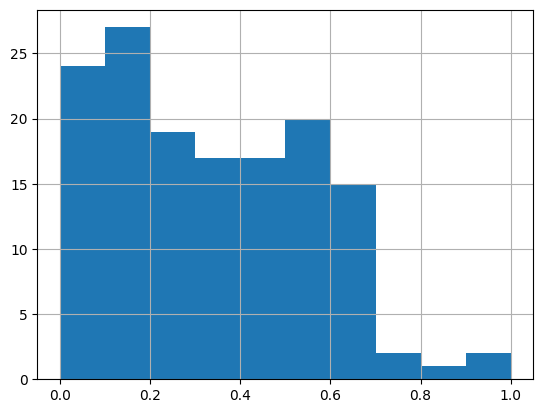

In [67]:
df_scaled['Passengers'].hist()

In [71]:
from tensorflow.keras import Input
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Attention
from keras.initializers import HeNormal
from tensorflow.keras.layers import LSTM, Dense, Input, Add
# Sequential model
from tensorflow.keras.layers import Lambda
def build_part3_RNN(window_size):
    RNN_model = Sequential()
    RNN_model.add(Input(shape=np.shape(X)[1:]))
    RNN_model.add(LSTM(50,activation='relu',return_sequences=True,kernel_regularizer=l2(0.01))) #,dropout=Float('droput',min_value=0.15, max_value=0.99, step=0.05)))
    #RNN_model.add(Dropout(0.1))
    RNN_model.add(LSTM(50,activation='relu',return_sequences=True, kernel_regularizer=l2(0.01)))
    RNN_model.add(LSTM(10,activation='relu',kernel_regularizer=l2(0.01)))
    RNN_model.add(Dense(1))
    return RNN_model


import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, Attention, Add, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def build_part3_RNN_with_attention(window_size):
    # Define the input shape
    input_shape = (window_size, X.shape[2])  # Adjust X.shape[2] to your number of features

    # Define the inputs
    inputs = Input(shape=input_shape)

    # LSTM layers
    lstm_out1 = LSTM(50, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01))(inputs)
    lstm_out2 = LSTM(50, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01))(lstm_out1)
    lstm_out3 = LSTM(10, activation='relu', kernel_regularizer=l2(0.01))(lstm_out2)

    # Define the attention mechanism
    attention = Attention(use_scale=True)([lstm_out2, lstm_out2])  # Attention applied on lstm_out2
    added = Add()([lstm_out2, attention])  # Element-wise addition

    # Add a dense layer
    dense_out = Dense(1)(lstm_out3)  # Using lstm_out3 for final output

    # Create the model
    model = Model(inputs=inputs, outputs=dense_out)

    return model

In [72]:
# import keras network libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow.keras

# given - fix random seed - so we can all reproduce the same results on our default time series
np.random.seed(0)

window_size = 10

model = build_part3_RNN(window_size)

# build model using keras documentation recommended optimizer initialization
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

With your model built you can now fit the model by activating the cell below!  Note: the number of epochs (np_epochs) and batch_size are preset (so we can all produce the same results).  You can choose to toggle the verbose parameter - which gives you regular updates on the progress of the algorithm - on and off by setting it to 1 or 0 respectively.

In [73]:
# run your model!
callback = keras.callbacks.EarlyStopping(monitor='loss',
                                              patience=7)
history = model.fit(X_train, y_train, validation_data=[X_test,y_test], epochs=500, batch_size=20, verbose=0,  callbacks=[callback])

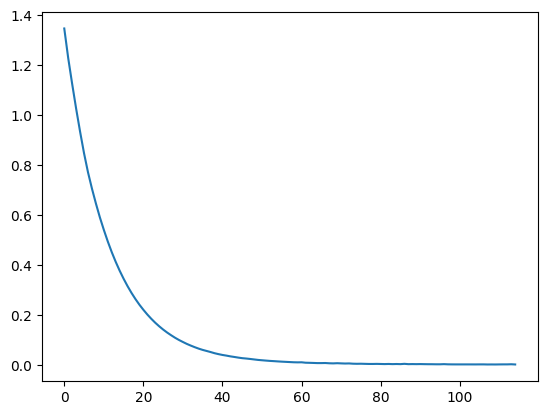

In [74]:
plt.plot(history.history['loss'])

In [75]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                  │ (None, 10, 50)         │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 10, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 10)             │         2,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,355 (392.02 KB)

 Trainable params: 33,451 (130.67 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 66,904 (261.35 KB)

## 1.5  Checking model performance

With your model fit we can now make predictions on both our training and testing sets.

In [76]:
df_scaled.shape

(144, 3)

In [77]:
import numpy as np
import tensorflow as tf
def prepare_forecat_data(df, input_window, output_window, target):
    """
    Prepares multivariate time series data for RNN processing using a rolling window approach.
    
    Parameters:
        df (pd.DataFrame): The multivariate time series as a pandas DataFrame.
        input_window (int): Number of time steps used as input (X).
        output_window (int): Number of time steps used as output (y).
        
    Returns:
        X (np.array): Input sequences of shape (num_samples, input_window, num_features).
    """
    
#     if target_columns is None:
#         target_columns = df.columns  # Use all columns if target_columns is not provided
    
    exogenous, data = [], []
    
    for i in range(len(df) - input_window - output_window + 1):
        exogenous.append(df[[x for x in df.columns if x!=target]].iloc[i:i+input_window].values)
        #data.append(df[[x for x in df.columns if x==target ]].iloc[i:i+input_window].values)
        data.append(df.iloc[i:i+input_window][target].values)
    return np.array(data), np.array(exogenous)

def rolling_window_prediction(model, data, exogenous_inputs,df_scaled, window_size, forecast_steps=1):
    """
    Generates rolling window time series predictions using a pre-trained LSTM model.
    
    Parameters:
        model: Pre-trained TensorFlow model (LSTM).
        data: numpy array of the main time series data (shape: [n_samples, n_features]).
        exogenous_inputs: numpy array of exogenous inputs (shape: [n_samples, n_exogenous_features]).
        window_size: Size of the rolling window.
        forecast_steps: Number of time steps to predict at each iteration.
    
    Returns:
        predictions: List of predicted values.
    """
    
    # Initialize a list to store predictions
    predictions = []
    data = np.expand_dims(data, axis=-1) 
    # Combine time series data and exogenous inputs
    #data_internal=data
    combined_data = np.concatenate((data, exogenous_inputs),axis=2)
    df_scaled_interal=df_scaled
    # Number of time steps we can predict using rolling windows
    num_samples = len(data) - window_size
    print(combined_data.shape)
    for i in range(num_samples):
        #print('i is:',i)
        # Extract the input window (input for the model)
        #input_window = combined_data[i:i+window_size]
        
        # Reshape to match model input shape (batch_size, window_size, n_features)
        #input_window = np.expand_dims(input_window, axis=0)  # Add batch dimension

        # Get the prediction (the output is a sequence, take the last step if forecast_steps > 1)
        #prediction = model.predict(input_window)
        prediction = model.predict(combined_data[i,:,:].reshape(1,10,3), verbose=False)
        #print("prediction.shape is",prediction.shape)
        
        # Append prediction
        predictions.append(prediction[0][-1] if forecast_steps > 1 else prediction[0])
        #print("what you need is",df_scaled_interal.iloc[i+1+window_size])
        #print("df_scaled_interal shape pre",df_scaled_interal.shape)
        if i>=train_test_split:
            df_scaled_interal.loc[i+1+window_size,target] = prediction        
            #print("df_scaled_interal shape post",df_scaled_interal.shape)
        data_internal,_  = prepare_forecat_data(df_scaled_interal, input_window=10, output_window=1, target=['Passengers']) 
        #print(data_internal.shape, exogenous_inputs.shape)

        combined_data = np.concatenate((data_internal, exogenous_inputs),axis=2)  
        #print(combined_data.shape)
        
    return np.array(predictions)

exogenous_inputs = X[:,:,[1,2]]
data = X[:,:,0]
#Define window size and forecast steps
window_size = 10
forecast_steps = 1

predictions = rolling_window_prediction(model, data, exogenous_inputs,df_scaled, window_size, forecast_steps)

(134, 10, 3)


In [78]:
# print out training and testing errors
training_error = model.evaluate(X_train, y_train, verbose=0)
print('training error = ' + str(training_error))

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('testing error = ' + str(testing_error))

training error = 0.002324138069525361
testing error = 0.010649981908500195


In [79]:
# Inverse scaling for predictions
def inverse_scale(scaler, predictions, target_index):
    # Inverse scale only the target column
    full_scaled = np.zeros((len(predictions), scaler.n_features_in_))
    full_scaled[:, target_index] = predictions.flatten()
    return scaler.inverse_transform(full_scaled)[:, target_index]

In [80]:
target_column = 'Passengers'
target_index = list(airpass.columns).index(target_column)

In [81]:
predictions.shape,airpass.shape

((124, 1), (144, 3))

In [82]:
train_predict = inverse_scale(scaler, predictions, 0)[0:train_test_split]
test_predict = inverse_scale(scaler, predictions, 0)[train_test_split:]

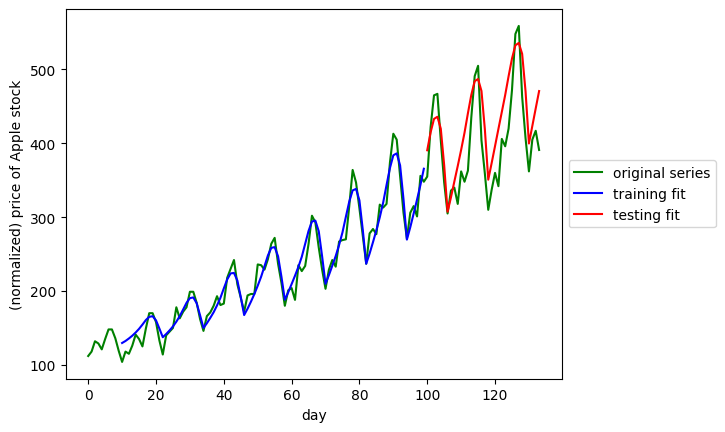

In [83]:
### Plot everything - the original series as well as predictions on training and testing sets
import matplotlib.pyplot as plt
%matplotlib inline

# plot original series
plt.plot(airpass['Passengers'].iloc[:134],color = 'g')

# plot training set prediction
split_pt = train_test_split + window_size 
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# plot testing set prediction
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('(normalized) price of Apple stock')
plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

**Note:** you can try out any time series for this exercise!  If you would like to try another see e.g., [this site containing thousands of time series](https://datamarket.com/data/list/?q=provider%3Atsdl) and pick another one!

In [84]:
from sklearn.metrics import mean_absolute_percentage_error
train_mape = mean_absolute_percentage_error(airpass['Passengers'][10:100], train_predict) 
test_mape = mean_absolute_percentage_error(airpass['Passengers'][100:134], test_predict) 
print(f'MAPE on Train data is: { round(train_mape*100,1)} %')
print(f'MAPE on Test data is: { round(test_mape*100,1)} %')

MAPE on Train data is: 5.6 %
MAPE on Test data is: 10.0 %
